# Transfer Learning
---

According to [tensorflow2021transfer], the idea of transfer learning for image classification is that if a model is trained on a *large and general enough dataset*, this model will serve as a generic model (...). We can take advantage of the learned feature maps without having to start from scratch by training a large model on a large dataset.

In summary, transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem [keras2021transfer].

The work from [yosinski2014how] argues that many deep neural networks trained on natural images exhibit a similar  phenomenon: first layers learn features that appear not to be specific to a particular dataset or task, but general in that they are applicable to many datasets and tasks. Those features are generally related to edge or color blob detectors.

From [cs231], there is an indication of common scenarios for Transfer Learning in a ConvNet:
* **Feature extractor**. Use a ConvNet pretrained using a very large dataset (for example ImageNet - 1.2 million images and 1000 categories), removing the last fully-connected layer as a feature extractor, to train a linear classifier (SVM or Softmax).
* **Fine-tuning**. Use pretrained ConvNet as the starting point, but continuing the backpropagation (tuning all layers or part of the layers, by freezing them, like the edge/blob detectors). *This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.*



## Considerations on Transfer Learning with different image domains
---
The following test was based on the evaluation around 2,500 images from 6 different datasets (~15,000 images):

* Brazilian Coffee Scene, 37K samples with RGNIR [penatti2015]
* EuroSAT, 27K samples with up to 13 bands (including RGNIR) [helber2019]
* SAT-4/SAT-6, 405K samples with RGBNIR [basu2015]
* PatternNet, 30K samples with RGB [zhou2018]
* Places365, 10M samples with RGB [zhou2014]
* UC Merced, 2K samples with RGB [yang2010]

By applying the well-known Canny edge detector with default parameters, and computing the ratio between the number of detected edges for each band, and the
number of pixels of the image, the aim was to start to explore the differences between using only RGB (Red, Green and Blue) and RGNIR (Red, Green and Near-Infrared).

<img src="https://github.com/tkorting/remote-sensing-images/raw/master/detected_borders_in_rgbnir.png" width=800>

From [cs231]:
* when using a pretrained network, you may be slightly constrained in terms of the architecture you can use for your new dataset.
* It’s common to use a smaller learning rate for ConvNet weights that are being fine-tuned

# Testing transfer learning (ImageNet + EuroSAT)

In this example, we will try 2 different classifications:
* instantiate a well-known architecture (e.g. ResNet50) with random weights, train with EuroSAT
* instantiate the same well-known architecture, but pretrained with ImageNet, and fine-tune with EuroSAT

*Obs.: There is a tutorial to download and load [EuroSAT](https://github.com/phelber/eurosat) database available at [this link](https://colab.research.google.com/github/e-chong/Remote-Sensing/blob/master/EuroSAT%20Land%20Cover%20Classification/EuroSAT%20Land%20Use%20and%20Land%20Cover%20Classification%20using%20Deep%20Learning.ipynb#scrollTo=IppT1bDRQKge).*

In [ ]:
# download EuroSAT data
import zipfile
import requests
import io
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]

# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])
N = len(XImages)

i = 0
for pic in txtfiles:
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255
  i += 1

del r # clear memory
del z

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


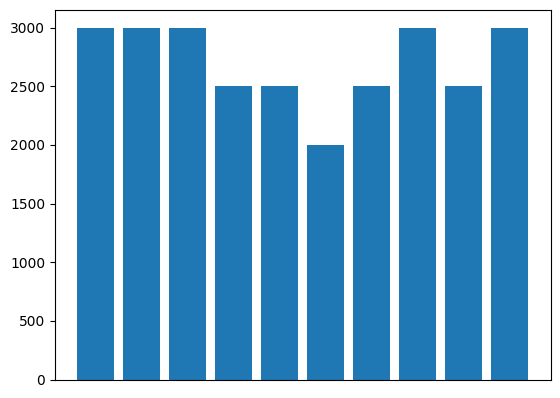

In [ ]:
# get labels in numpy array as strings
labels = []
for label in txtfiles:
  labels.append(label.split('/')[1])

# change them to integers in alphabetical order
label_names, yLabels = np.unique(labels, return_inverse=True)
label_dictionary = dict(zip(np.unique(yLabels), label_names))

# show number of samples per class
print(label_dictionary)
plt.hist(yLabels, rwidth=0.8)
plt.xticks([])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# create X_train -> y_train, and X_test -> y_test
X_train, X_test, y_train, y_test = train_test_split(XImages,
                                                    yLabels,
                                                    stratify = yLabels,
                                                    train_size = 0.25,
                                                    random_state = 42)

print('XImages.shape:', XImages.shape, 'len(yLabels):', len(yLabels))
print('X_train.shape:', X_train.shape, 'len(y_train):', len(y_train))
print('X_test.shape:', X_test.shape, 'len(y_test):', len(y_test))

XImages.shape: (27000, 64, 64, 3) len(yLabels): 27000
X_train.shape: (6750, 64, 64, 3) len(y_train): 6750
X_test.shape: (20250, 64, 64, 3) len(y_test): 20250


In [ ]:
# import the necessary packages
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
import tensorflow

# retrieve metadata from EuroSAT
IMG_WIDTH = XImages.shape[1]
IMG_HEIGHT = XImages.shape[2]
IMG_CHANNELS = XImages.shape[3]

# define constants for classifications
INIT_LR = 1e-4 # initial learning rate
NUM_EPOCHS = 13 # number of epochs for training

In [ ]:
#################
# the randomModel is created with random weights
randomModel = MobileNetV2(weights = None,
                          include_top = True,
                          input_tensor = Input(shape=(IMG_WIDTH,
                                                      IMG_HEIGHT,
                                                      IMG_CHANNELS)),
                          classes = len(label_dictionary))

# specify the training configuration (optimizer, loss, metrics)
opt = Adam(learning_rate = INIT_LR)
randomModel.compile(loss = SparseCategoricalCrossentropy(),
                    optimizer = opt,
                    metrics = ["accuracy"])

history_randomModel = randomModel.fit(
  X_train, y_train,
  epochs = NUM_EPOCHS,
  validation_data = (X_test, y_test)
)

Epoch 1/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 215s 830ms/step - accuracy: 0.3144 - loss: 1.8533 - val_accuracy: 0.1111 - val_loss: 2.3032
Epoch 2/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 196s 804ms/step - accuracy: 0.4938 - loss: 1.3863 - val_accuracy: 0.1111 - val_loss: 2.3107
Epoch 3/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 225s 915ms/step - accuracy: 0.5639 - loss: 1.2038 - val_accuracy: 0.1111 - val_loss: 2.3221
Epoch 4/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 170s 805ms/step - accuracy: 0.5980 - loss: 1.0861 - val_accuracy: 0.0926 - val_loss: 2.3414
Epoch 5/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 201s 802ms/step - accuracy: 0.6499 - loss: 0.9809 - val_accuracy: 0.1111 - val_loss: 2.3665
Epoch 6/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 191s 909ms/step - accuracy: 0.6505 - loss: 0.9429 - val_accuracy: 0.1111 - val_loss: 2.4113
Epoch 7/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 180s 802ms/step - accuracy: 0.6915 - loss: 0.8411 - val_accuracy: 0.1111 - val_loss: 2.4506
Epoch 8/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 201s 798ms/step - accuracy: 0.6993 -

In [ ]:
# define tail and head to adapt MobileNetV2 pretrained with ImageNet
# to EuroSAT data
tailModel = MobileNetV2(weights = "imagenet",
                        include_top = False)
dense_input = Input(shape=(IMG_WIDTH,
                           IMG_HEIGHT,
                           IMG_CHANNELS))
dense_filter = Conv2D(3, 3, padding='same')(dense_input)
output = tailModel(dense_filter)
tailModel = Model(dense_input, output)

# construct the head of the model that will be placed on top of tailModel
headModel = tailModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(label_dictionary), activation="softmax")(headModel)

###################
# the pretrainedModel is created with random pretrained weights, from ImageNet
pretrainedModel = Model(tailModel.input, headModel)

# specify the training configuration (optimizer, loss, metrics)
opt = Adam(learning_rate = INIT_LR)
pretrainedModel.compile(loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(),
                        optimizer = opt,
                        metrics = ["accuracy"])

################################## ????????????
# base_model.trainable = True
# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

history_pretrainedModel = pretrainedModel.fit(
  X_train, y_train,
  epochs = NUM_EPOCHS,
  validation_data = (X_test, y_test)
)

<ipython-input-6-dd116afe4566>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  tailModel = MobileNetV2(weights = "imagenet",


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 245s 994ms/step - accuracy: 0.3240 - loss: 2.1996 - val_accuracy: 0.1155 - val_loss: 8.8218
Epoch 2/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 201s 956ms/step - accuracy: 0.7409 - loss: 0.8167 - val_accuracy: 0.1111 - val_loss: 11.5976
Epoch 3/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 189s 896ms/step - accuracy: 0.8310 - loss: 0.5586 - val_accuracy: 0.1203 - val_loss: 8.8862
Epoch 4/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 215s 957ms/step - accuracy: 0.8543 - loss: 0.4424 - val_accuracy: 0.1290 - val_loss: 9.1326
Epoch 5/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 202s 959ms/step - accuracy: 0.8898 - loss: 0.3353 - val_accuracy: 0.1545 - val_loss: 8.2516
Epoch 6/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 189s 894ms/step - accuracy: 0.9041 - loss: 0.3037 - val_accuracy: 0.1798 - val_loss: 6.0698
Epoch 7/13
211/211 ━━━━━━━━━━━━━━━━━━━━ 202s 959ms/step - accuracy: 0.9069 - loss: 0.2812 - val_accuracy: 0.2404 - val_loss: 4.8971
Epoch 8/13
211/211 ━━━━━━━

# Exercise
---

Create 2 different classifications, now exploring the EuroSAT database with Red, Green and Near-Infrared bands (RGNIR):
* instantiate a well-known architecture (e.g. ResNet50) with random weights, train with EuroSAT (RGNIR)
* instantiate the same well-known architecture, but pretrained with ImageNet, and fine-tune with EuroSAT (RGNIR)

Show plots of accuracy and loss along the epochs, for both cases.

# References

[tensorflow2021transfer] https://www.tensorflow.org/tutorials/images/transfer_learning

[keras2021transfer] https://www.tensorflow.org/guide/keras/transfer_learning

[cs231] **Convolutional Neural Networks for Visual Recognition**. Stanford Course. https://cs231n.github.io/transfer-learning

[yosinski2014how] Jason Yosinski, Jeff Clune, Yoshua Bengio, Hod Lipson. **How transferable are features in deep neural networks?** arXiv.org. https://arxiv.org/abs/1411.1792

[chollet2018] **Deep Learning with Phyton**. François Chollet. https://livebook.manning.com/book/deep-learning-with-python/

[penatti2015] O. Penatti et al. **Do deep features generalize from everyday
objects to remote sensing and aerial scenes domains?** IEEE
CVPR workshops.

[helber2019] P. Helber, B. Bischke, et al. **EuroSAT: A novel dataset and deep
learning benchmark for land use and land cover classification.** IEEE JSTARS.

[basu2015] S. Basu, S. Ganguly, et al. **Deepsat: A learning framework for
satellite imagery**. 23rd SIGSPATIAL.

[zhou2018] W. Zhou, S. Newsam, C. Li, and Z. Shao. **PatternNet: A benchmark dataset for performance evaluation of remote sensing image retrieval**. ISPRS P&RS.

[zhou2014] B. Zhou, A. Lapedriza, et al. **Learning deep features for scene
recognition using places database**. Advances in neural information processing systems.

[yang2010] Y. Yang and S. Newsam. **Bag-of-visual-words and spatial extensions for land-use classification**. SIGSPATIAL, GIS.


## The well-known example of cats Vs dogs
---

> *This section is based on [tensorflow2021transfer].*

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


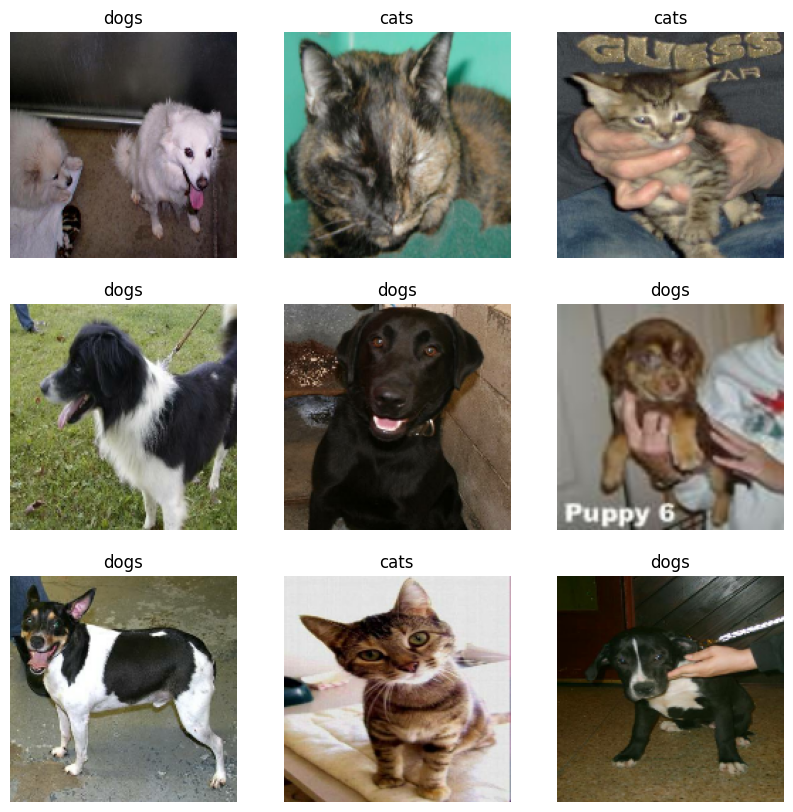

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

AttributeError: module 'tensorflow.keras.layers' has no attribute 'experimental'

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

It is important to **freeze** the convolutional base before you compile and train the model. *Freezing prevents the weights in a given layer from being updated during training*.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Up to here, the results were created using the base model from the MobileNet V2, developed at Google (pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes).

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)